In [1]:
import pandas as pd
import numpy as np # linear algebra
df_train=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [2]:
import ydata_profiling

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [3]:
print(df_train.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [4]:
print(df_test.head())

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
profile = df_train.profile_report()
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
profile = df_test.profile_report()
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [9]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [11]:
missing_cols = ['keyword', 'location']
for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [12]:
df_train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [13]:
df_test.isnull().sum()

id          0
keyword     0
location    0
text        0
dtype: int64

In [14]:
def url_remover(text):
    url_patterns = re.compile(r'https?://S+|www.S+')
    return url_patterns.sub(r'', text)

In [15]:
X = df_train["text"] # indpendent feature
y = df_train["target"] # dependent feature
y = np.array(y) # converting to array

In [16]:
import re
import spacy
from tqdm import tqdm
from nltk.corpus import stopwords

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

def preprocessing(text):
    tweets = []

    for sentence in tqdm(text):
        sentence = sentence.lower() # converting the words to lower case
        sentence = url_remover(sentence) # removing the url from the sentence
        sentence = re.sub(r'@w+', '', sentence).strip() # removing the words starting with "@"
        sentence = re.sub("[^a-zA-Z0-9 ']", "", sentence) # removing symbols

        # Process the sentence using spaCy
        doc = nlp(sentence)

        # Lemmatization and stopwords removal from tweets
        sentence1 = [token.lemma_ for token in doc if not token.is_stop and token.text.isalpha()]
        sentence1 = " ".join(sentence1)
        tweets.append(sentence1)

    return tweets

tweets = preprocessing(X)

100%|██████████| 7613/7613 [01:12<00:00, 105.44it/s]


In [17]:

from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

# Import Tokenizer and pad_sequences for text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import train_test_split for splitting datasets
from sklearn.model_selection import train_test_split

# Import KeyedVectors and models from Gensim for word embeddings
from gensim.models import KeyedVectors
from gensim import models

# Import TSNE for dimensionality reduction and visualization
from sklearn.manifold import TSNE

# Import the 'random' module for randomization tasks
import random
import matplotlib.pyplot as plt


In [18]:
from tensorflow.keras.layers import (Embedding,
                                     LSTM,
                                     Dense,
                                     Dropout,
                                     GlobalMaxPool1D,
                                     BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

In [19]:
VOC_SIZE = 30000
onehot_vector = [one_hot(words, VOC_SIZE) for words in tweets]
onehot_vector[110:120]

[[12283, 14395, 5891, 1802, 13361, 24372, 20996],
 [14399, 20456, 26826, 28222, 20996, 25208],
 [20996, 20812, 21491, 8330, 10401, 5442],
 [20996, 29021],
 [24767, 23875, 20996, 15132, 18260, 18658, 28797, 5709, 3257, 23887],
 [24767, 23875, 20996, 15132, 18260, 18658, 28797, 5709, 3257, 23887, 8195],
 [24767, 23875, 20996, 15132, 18260, 18658, 28797, 5709, 3257, 23887],
 [12717, 6600, 10551, 20996],
 [24767, 23875, 20996, 15132, 18260, 18658, 28797, 5709, 3257, 23887],
 [24767, 23875, 20996, 15132, 18260, 18658, 28797, 5709, 3257, 23887]]

In [20]:
word_length = []
for i in onehot_vector:
    word_length.append(len(i))

In [21]:
len(word_length)

7613

In [22]:
max(word_length)

21

In [23]:
SENTENCE_LENGTH = 15
embedded_docs = pad_sequences(onehot_vector, padding="post", maxlen=SENTENCE_LENGTH)
embedded_docs

array([[25588,  5994, 12706, ...,     0,     0,     0],
       [ 7683,  3202,  9814, ...,     0,     0,     0],
       [ 1582, 22250,  5558, ...,     0,     0,     0],
       ...,
       [ 5813,  2415,  9410, ...,     0,     0,     0],
       [23683, 11306, 28824, ..., 14955,     0,     0],
       [20266, 11845, 13637, ...,     0,     0,     0]], dtype=int32)

In [24]:
# Rest of your code
x_train, x_test, y_train, y_test = train_test_split(embedded_docs, y, test_size=0.2, random_state=42)

In [25]:
def model():
    VECTOR_FEATURES = 32
    lstm_model = Sequential()
    lstm_model.add(Embedding(VOC_SIZE,
                      VECTOR_FEATURES,
                      input_length=SENTENCE_LENGTH))
    lstm_model.add(LSTM(100, return_sequences = True))
    lstm_model.add(GlobalMaxPool1D())
    lstm_model.add(BatchNormalization())
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(10, activation="relu"))
    lstm_model.add(Dropout(0.25))
    lstm_model.add(Dense(1, activation = "sigmoid"))
    return lstm_model

In [26]:
lstm_model = model()
lstm_model.summary() #summary
lstm_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 32)            960000    
                                                                 
 lstm (LSTM)                 (None, 15, 100)           53200     
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 10)                1

In [27]:
history = lstm_model.fit(x_train, y_train, epochs=8, batch_size=32)

Epoch 1/8
191/191 [==============================] - 7s 19ms/step - loss: 0.5772 - accuracy: 0.7002
Epoch 2/8
191/191 [==============================] - 4s 19ms/step - loss: 0.3556 - accuracy: 0.8534
Epoch 3/8
191/191 [==============================] - 4s 19ms/step - loss: 0.2309 - accuracy: 0.9149
Epoch 4/8
191/191 [==============================] - 4s 19ms/step - loss: 0.1656 - accuracy: 0.9425
Epoch 5/8
191/191 [==============================] - 4s 21ms/step - loss: 0.1356 - accuracy: 0.9548
Epoch 6/8
191/191 [==============================] - 4s 19ms/step - loss: 0.1017 - accuracy: 0.9637
Epoch 7/8
191/191 [==============================] - 4s 19ms/step - loss: 0.0842 - accuracy: 0.9663
Epoch 8/8
191/191 [==============================] - 4s 19ms/step - loss: 0.0870 - accuracy: 0.9665


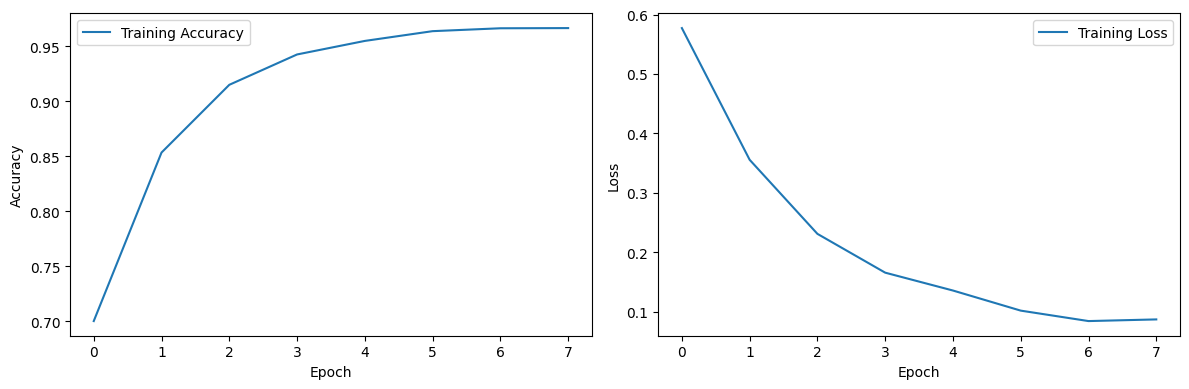

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

In [29]:
loss, accuracy = lstm_model.evaluate(x_train, y_train, verbose=0)

print('Training Accuracy: {}%'.format(accuracy * 100))

Training Accuracy: 97.75041341781616%


In [30]:
from sklearn.metrics import classification_report

# Evaluate the model
loss, accuracy = lstm_model.evaluate(x_train, y_train, verbose=0)

# Make predictions
y_pred = lstm_model.predict(x_train)
y_pred = (y_pred > 0.5).astype(int)

# Generate classification report
report = classification_report(y_train, y_pred)
print(report)

191/191 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3468
           1       0.97      0.98      0.97      2622

    accuracy                           0.98      6090
   macro avg       0.98      0.98      0.98      6090
weighted avg       0.98      0.98      0.98      6090



191/191 [==============================] - 1s 5ms/step


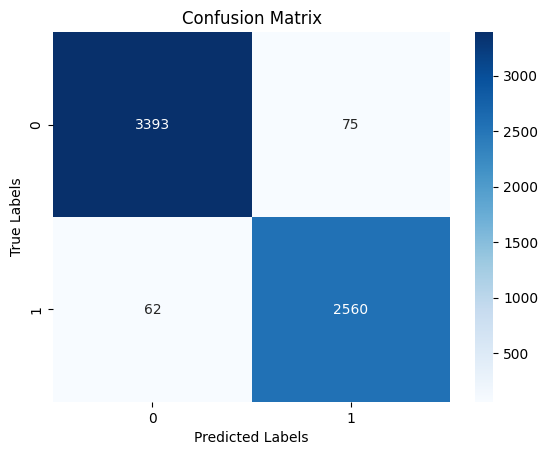

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluate the model
loss, accuracy = lstm_model.evaluate(x_train, y_train, verbose=0)

# Make predictions
y_pred = lstm_model.predict(x_train)
y_pred = (y_pred > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
word2vec = KeyedVectors.load_word2vec_format('/kaggle/input/data-nlp1/GoogleNews-vectors-negative300.bin', binary=True) 
print('loaded successfully..!')

loaded successfully..!


In [33]:
word2vec.most_similar('river')

[('creek', 0.7994443774223328),
 ('lake', 0.7919586896896362),
 ('rivers', 0.7777560949325562),
 ('riverbank', 0.7283665537834167),
 ('canal', 0.722176194190979),
 ('River', 0.7170898914337158),
 ('waterway', 0.7110065817832947),
 ('tributary', 0.7063449621200562),
 ('riverbed', 0.6722352504730225),
 ('downriver', 0.6608339548110962)]

In [34]:
word_embed= word2vec['river']
print(word_embed)

[ 8.36181641e-03  1.81640625e-01  8.98437500e-02  7.22656250e-02
  1.18652344e-01 -9.17968750e-02 -1.50390625e-01 -9.08203125e-02
  2.57812500e-01  3.15856934e-03  2.42187500e-01 -7.32421875e-02
  6.15234375e-02  2.14843750e-02 -1.86767578e-02 -3.14453125e-01
 -4.54711914e-03 -1.28906250e-01  3.89099121e-03 -1.14257812e-01
 -1.32812500e-01  4.39453125e-02 -6.44531250e-02 -4.19921875e-02
  3.32031250e-01 -3.55468750e-01 -1.86523438e-01 -6.25000000e-02
  1.13769531e-01 -1.62109375e-01 -2.09960938e-01  2.79296875e-01
 -1.16210938e-01  5.54199219e-02 -2.55859375e-01 -1.65039062e-01
  6.49414062e-02 -1.36718750e-02 -3.63769531e-02 -9.61914062e-02
 -5.35156250e-01  3.97949219e-02  2.29492188e-01 -7.76367188e-02
 -2.85156250e-01 -3.63281250e-01 -5.56640625e-02  1.27929688e-01
 -4.80957031e-02  2.36328125e-01  2.94921875e-01 -5.63964844e-02
  8.25195312e-02 -1.66015625e-01  8.54492188e-03 -2.02636719e-02
  8.30078125e-03  8.44726562e-02  3.26171875e-01  1.78710938e-01
  1.91406250e-01 -2.69775

In [35]:
distance = word2vec.distance("river", "lake")
print(f"{distance:.1f}")

0.2


In [36]:
distance = word2vec.distance("river", "sea")
print(f"{distance:.1f}")

0.5


In [37]:
distance = word2vec.distance("river", "river")
print(f"{distance:.1f}")

-0.0


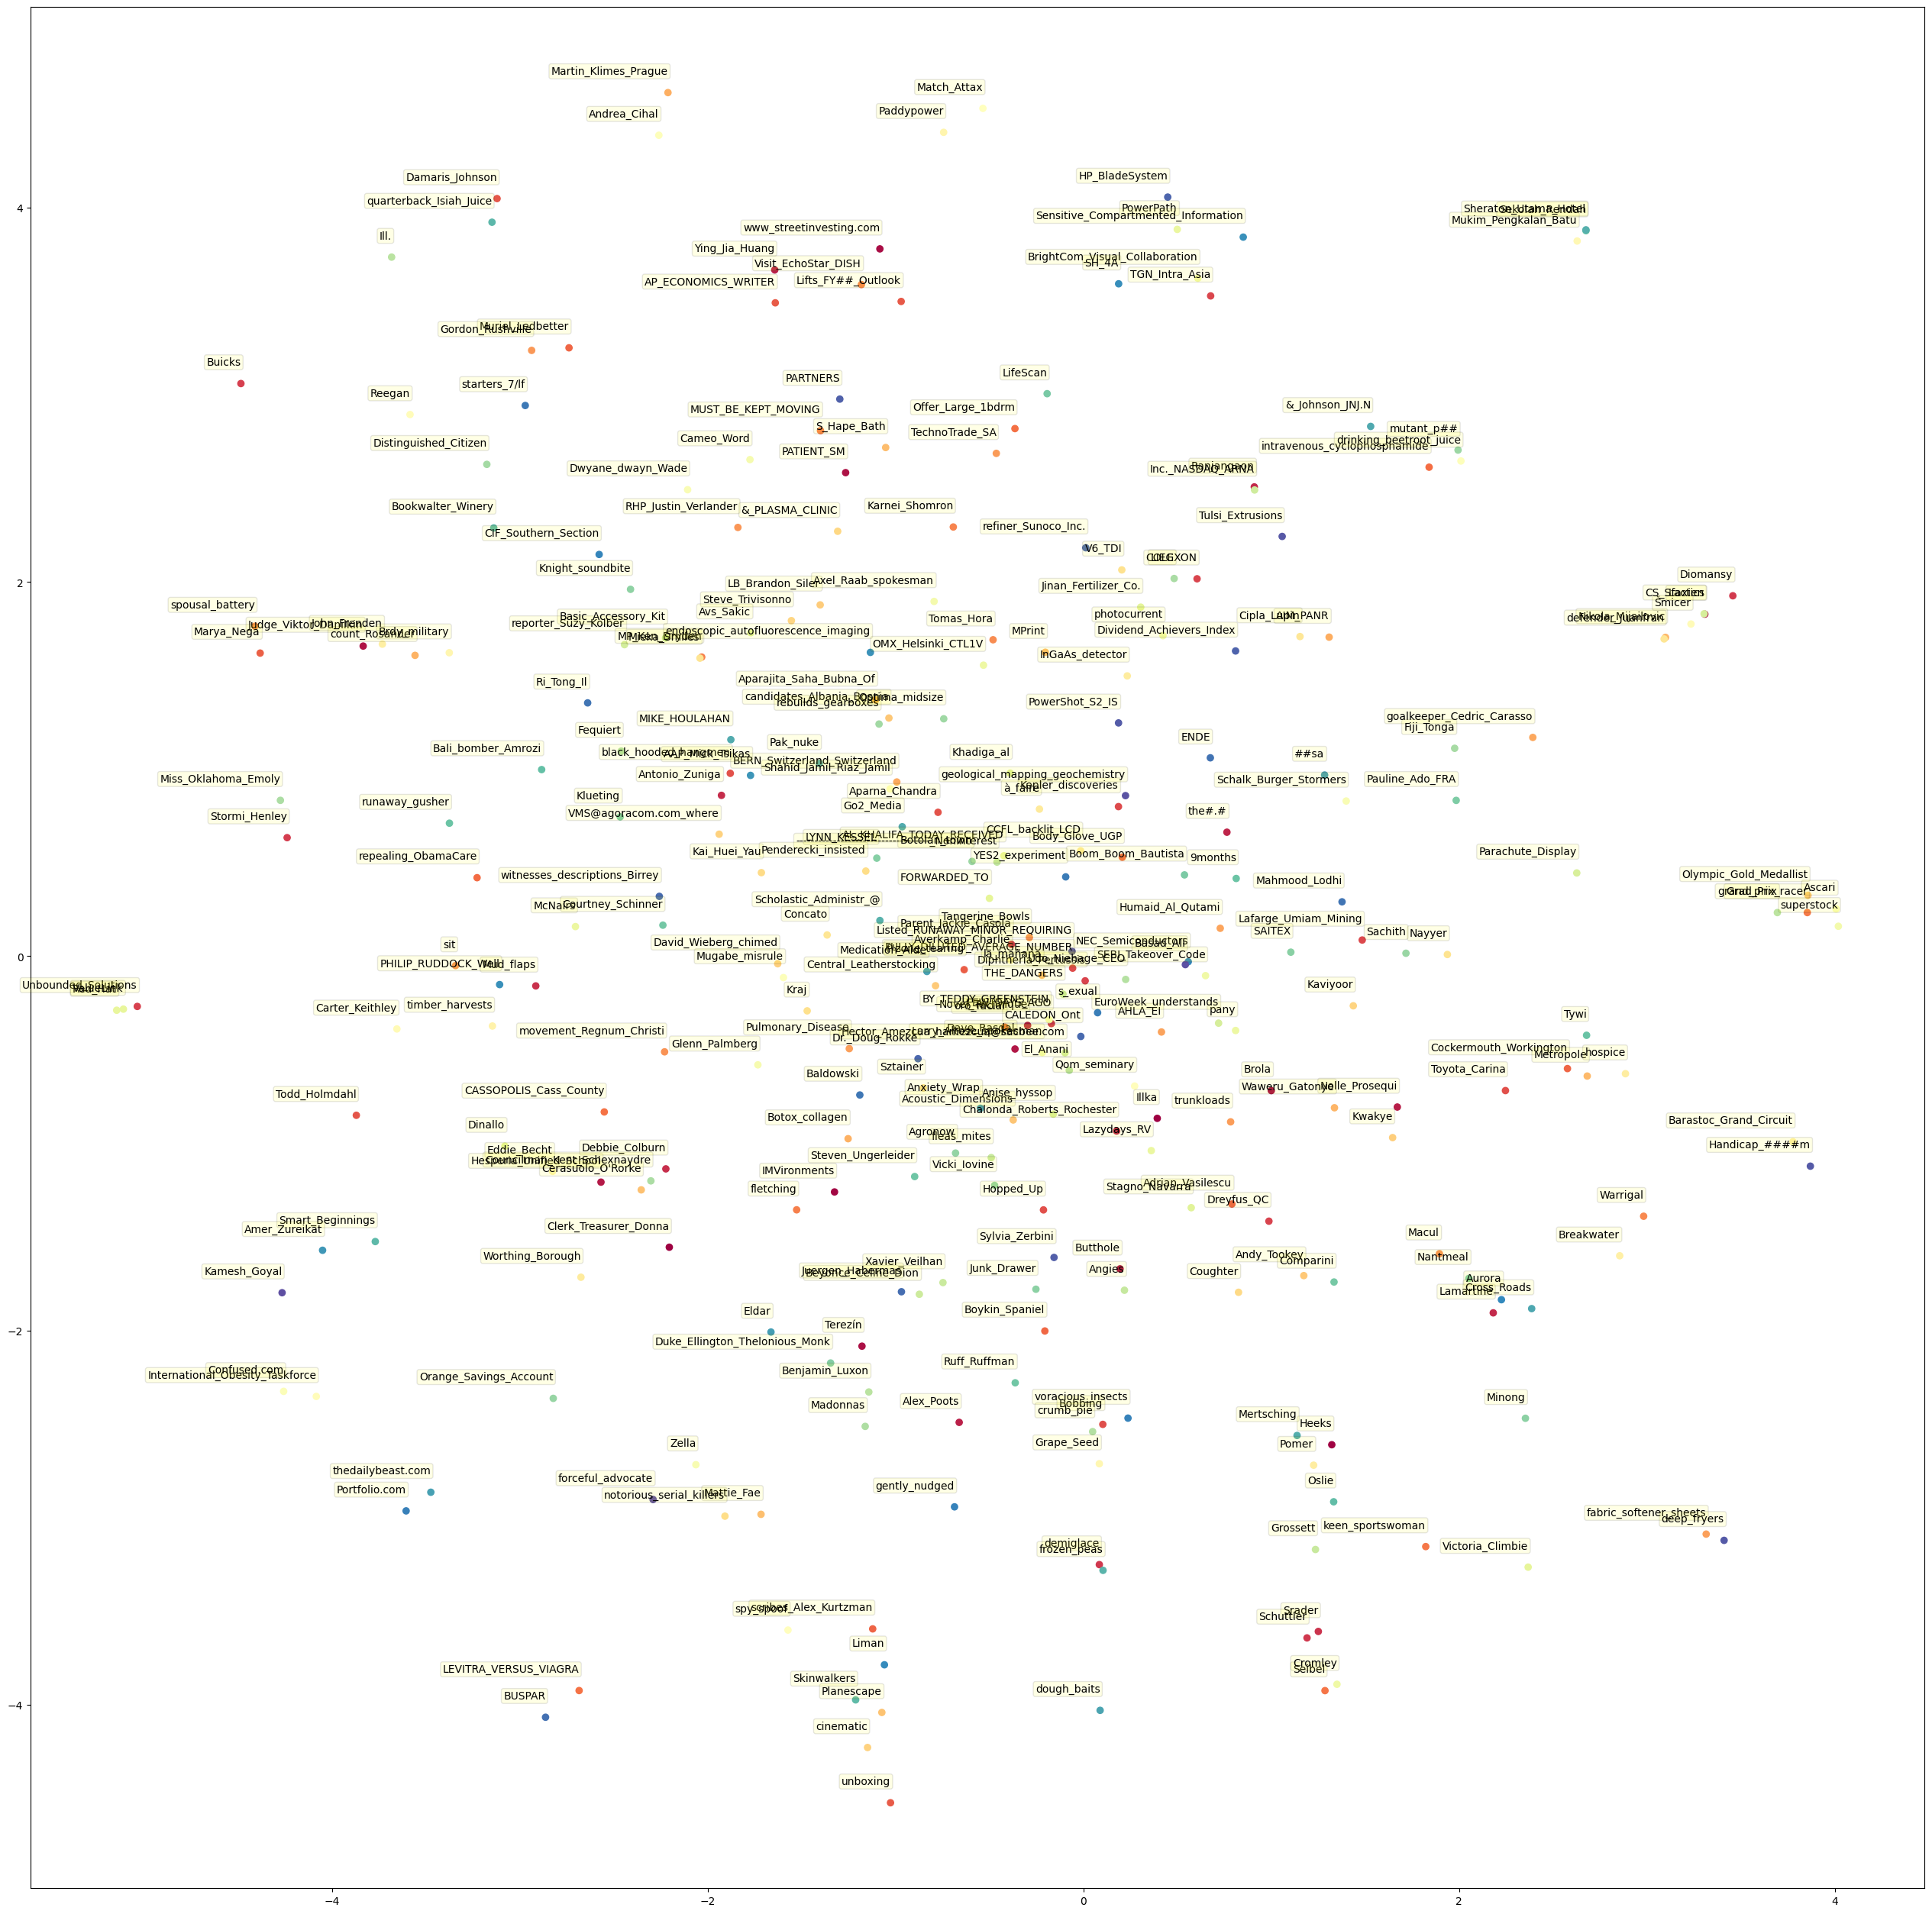

In [40]:
w2v_weights = word2vec.vectors
VOC_SIZE, embedded_docs = w2v_weights.shape
def word2token(word):
    try:
        return word2vec.vocab[word].index
    except KeyError:
        return 0
def token2word(token):
    return word2vec.index_to_key[token]


n_samples = 300
# Sample random words from model dictionary
random_i = random.sample(range(VOC_SIZE), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate Word2Vec embeddings of each word
word_vecs = np.array([word2vec[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))